In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)

from transformers.trainer_pt_utils import get_parameter_names
from transformers.optimization import get_linear_schedule_with_warmup

from dataclasses import dataclass, field
from torch.utils.data import Dataset
from collections import defaultdict
import numpy as np
import os
import random
import time
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

# 初始化路径和任务参数
MODEL_DIR = "./data/xiaobu"
DATA_DIR = "../data"
OUTPUT_DIR = "./output_data"
TASK_NAME = "KUAKE-QQR"
MAX_LENGTH = 64
BATCH_SIZE = 16
EPOCHS = 3
LABELS = 3


@dataclass
class DataTrainingArguments:

    model_dir: str = field(
        default= MODEL_DIR,
        metadata={'help': 'The pretrained model directory'}
    )
    data_dir: str = field(
        default=DATA_DIR,
        metadata={'help': 'The data directory'}
    )
    max_length: int = field(
        default=MAX_LENGTH,
        metadata={'help': 'Maximum sequence length allowed to input'}
    )

    task_name: str = field(
        default=TASK_NAME,
        metadata={'help': 'The name of the task to train on'}
    )

    labels: int = field(
        default=LABELS,
        metadata={'help': 'The number of labels in the dataset'}
    )

    def __str__(self):
        self_as_dict = dataclasses.asdict(self)
        attrs_as_str = [f"{k}={v},\n" for k, v in sorted(self_as_dict.items())]
        return f"{self.__class__.__name__}(\n{''.join(attrs_as_str)})"
        
    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"

@dataclass
class TrainingArguments:

    output_dir: str = field(
        default='output_data/',
        metadata={'help': 'The output directory where the model predictions and checkpoints will be written.'}
    )
    train_batch_size: int = field(
        default=BATCH_SIZE,
        metadata={'help': 'batch size for training'}
    )
    eval_batch_size: int = field(
        default=1,
        metadata={'help': 'batch size for evaluation'}
    )
    gradient_accumulation_steps: int = field(
        default=1,
        metadata={'help': 'Number of updates steps to accumulate before performing a backward/update pass.'}
    )
    num_train_epochs: int = field(
        default=EPOCHS,
        metadata={"help": "The total number of training epochs"}
    )
    learning_rate: float = field(
        default=3e-5,
        metadata={'help': '"The initial learning rate for AdamW.'}
    )
    weight_decay: float = field(
        default=0.0,
        metadata={"help": "Weight decay for AdamW"}
    )
    warmup_ratio: float = field(
        default=0.05,
        metadata={"help": "Linear warmup over warmup_ratio fraction of total steps."}
    )
    dataloader_num_workers: int = field(
        default=0,
        metadata={"help": "Number of subprocesses to use for data loading (PyTorch only)"}
    )
    
    logging_steps: int = field(
        default=100,
        metadata={'help': 'logging states every X updates steps.'}
    )
    eval_steps: int = field(
        default=50,
        metadata={'help': 'Run an evaluation every X steps.'}
    )
    device: str = field(
        default= "cuda" if torch.cuda.is_available() else "cpu",
        metadata={"help": 'The device used for training'}
    )

    tolerance: float = field(
        default=0.1,
        metadata={"help": "Tolerance for early stopping"}
    )

    def get_warmup_steps(self, num_training_steps):
        return int(num_training_steps * self.warmup_ratio)

    def __str__(self):
        self_as_dict = dataclasses.asdict(self)
        attrs_as_str = [f"{k}={v},\n" for k, v in sorted(self_as_dict.items())]
        return f"{self.__class__.__name__}(\n{''.join(attrs_as_str)})"
        
    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"



def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用GPU
    torch.backends.cudnn.deterministic = True  # 确保每次使用相同的算法
    torch.backends.cudnn.benchmark = False  # 如果输入大小变化不大，关闭此项以确保可重复性

def load_data(data_dir, task_name, augment=False):
    train_path = os.path.join(data_dir, f"{task_name}_train.json")
    dev_path = os.path.join(data_dir, f"{task_name}_dev.json")
    test_path = os.path.join(data_dir, f"{task_name}_test.json")

    def read_file(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            return json.load(f)

    def preprocess_valid(samples):
        processed_samples = []
        for sample in samples:
            label = sample.get("label", None)
            if label == "NA":
                continue
            try:
                label = int(label)
            except (ValueError, TypeError):
                continue
            query1 = sample["query1"]
            query2 = sample["query2"]
            processed_samples.append({
                "text_a": query1,
                "text_b": query2,
                "label": label,
            })
        return processed_samples

    def preprocess_train(samples):
        processed_samples = []
        
        grouped_data = defaultdict(lambda: [[], []])
        for sample in samples:
            label = sample.get("label", None)
            if label == "NA":
                continue
            try:
                label = int(label)
            except (ValueError, TypeError):
                continue
            query1 = sample["query1"]
            query2 = sample["query2"]
            grouped_data[query1][0].append(query2)
            grouped_data[query1][1].append(label)
        

        new_grouped_data = defaultdict(lambda: [[], []])
        if augment:
            for query, keys in grouped_data.items():
                key, label = keys
                key2, key1, key0 = [], [], []
                for i in range(len(label)):
                    if label[i] == 2:
                        key2.append(key[i])
                    elif label[i] == 1:
                        key1.append(key[i])
                    else:
                        key0.append(key[i])

                for i in range(len(key2)):

                    if query != key2[i]:
                        for j in range(i+1, len(key2)):
                            new_grouped_data[key2[i]][0].append(key2[j])
                            new_grouped_data[key2[i]][1].append(2)

                            new_grouped_data[key2[j]][0].append(key2[i])
                            new_grouped_data[key2[j]][1].append(2)

                        new_grouped_data[key2[i]][0].append(query)
                        new_grouped_data[key2[i]][1].append(2)

                        for j in range(len(key1)):
                            new_grouped_data[key2[i]][0].append(key1[j])
                            new_grouped_data[key2[i]][1].append(1)

                            new_grouped_data[key1[j]][0].append(key2[i])
                            new_grouped_data[key1[j]][1].append(0)
                        
                        for j in range(len(key0)):
                            new_grouped_data[key2[i]][0].append(key0[j])
                            new_grouped_data[key2[i]][1].append(0)

        grouped_data.update(new_grouped_data)
        for query1, keys in grouped_data.items():
            find_quary = False
            for quary2 in keys[0]:
                if quary2 == query1:
                    find_quary = True
                    break
            
            if not find_quary:
                keys[0].append(query1)
                keys[1].append(2)


        for query, keys in grouped_data.items():
            query1 = query
            key = keys[0]
            label = keys[1]
            for query2, label in zip(key, label):
                processed_samples.append({
                    "text_a": query1,
                    "text_b": query2,
                    "label": label,
                })


        return processed_samples

    def preprocess_test(samples):
        return [{
            "id": sample["id"],
            "text_a": sample["query1"],
            "text_b": sample["query2"],
            "label": -1,
        } for sample in samples]

    def load_and_preprocess(file_path, type_="train"):
        data = read_file(file_path)
        if type_ == "train":
            return preprocess_train(data)
        elif type_ == "valid":
            return preprocess_valid(data)
        else:
            return preprocess_test(data)


    return {
        "train": load_and_preprocess(train_path, type_="train"),
        "dev": load_and_preprocess(dev_path, type_="valid"),
        "test": load_and_preprocess(test_path, type_="test")
    }

In [3]:
data_args = DataTrainingArguments()
train_args = TrainingArguments()
data_args.data_dir = os.path.join(data_args.data_dir, data_args.task_name)
time_str = time.strftime("%Y%m%d-%H%M", time.localtime())
train_args.output_dir = os.path.join(train_args.output_dir, 'baseline', time_str)



In [4]:
data = load_data(data_args.data_dir, data_args.task_name)
data_aug = load_data(data_args.data_dir, data_args.task_name, augment=True)

In [4]:
print(f"Train data size: {len(data['train'])}")
print(f"Train data size: {len(data_aug['train'])}")

Train data size: 15410
Train data size: 83436


In [5]:
class KUAKEQQR_Dataset(Dataset):
    _id2label = ["0", "1", "2"]
    _label2id = {label: i for i, label in enumerate(_id2label)}
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.data[idx]["text_a"], self.data[idx]["text_b"], truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt")
        return {
            "input_ids": tokens["input_ids"].squeeze(),
            "attention_mask": tokens["attention_mask"].squeeze(),
            "labels": torch.tensor(self.data[idx]["label"])
        }
    
    @classmethod
    def id2label(cls, _id):
        return cls._id2label[_id]
    
    @classmethod
    def label2id(cls, label):
        return cls._label2id[label]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(data_args.model_dir)

train_dataset = KUAKEQQR_Dataset(data["train"], tokenizer)
dev_dataset = KUAKEQQR_Dataset(data["dev"], tokenizer)
test_dataset = KUAKEQQR_Dataset(data["test"], tokenizer)

In [7]:
data0 = train_dataset[0]
print(data0)

{'input_ids': tensor([ 101, 1921,  817, 6783, 3890, 6589,  102, 6783, 3890,  817, 3419,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor(0)}


In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_args.train_batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=train_args.eval_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=train_args.eval_batch_size, shuffle=False)

In [9]:
first = next(iter(test_loader))
print(first)
print(first["input_ids"].shape)
print(first["attention_mask"].shape)
print(first["labels"].shape)

{'input_ids': tensor([[ 101, 1957, 4495, 5018,  671, 3613, 1400, 1920, 2007, 1968, 6826, 1168,
          102, 5018,  671, 3613,  833,  679,  833, 2512, 1510, 1920, 2007, 1968,
         2972, 6826,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([-1])}
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1])


In [11]:
from transformers import AutoModel
LLM = AutoModel.from_pretrained(data_args.model_dir)

In [12]:
output = LLM(input_ids=data0["input_ids"].unsqueeze(0), attention_mask=data0["attention_mask"].unsqueeze(0))
print(output.last_hidden_state.shape)
print(output.pooler_output.shape)
print(f"max {output.pooler_output.max()}")
print(f"min {output.pooler_output.min()}")

torch.Size([1, 64, 1024])
torch.Size([1, 1024])
max 0.9505216479301453
min -0.9593271017074585


In [31]:
from transformers import AutoModel

class LLM(nn.Module):
    def __init__(self, model_dir, num_labels):
        super(LLM, self).__init__()
        self.llm = AutoModel.from_pretrained(model_dir)
        self.num_labels = num_labels
        self.classifier = nn.Linear(self.llm.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.llm(input_ids=input_ids, attention_mask=attention_mask)

        logits = self.classifier(outputs.pooler_output)
        return logits
    
    def criterion(self):
        return nn.CrossEntropyLoss()

In [10]:

def create_optimizer_and_scheduler(
    args: TrainingArguments,
    model: nn.Module,
    num_training_steps: int,
):
    decay_parameters = get_parameter_names(model, [nn.LayerNorm])
    decay_parameters = [name for name in decay_parameters if "bias" not in name]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if n in decay_parameters],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
            "weight_decay": 0.0,
        },
    ]

    optimizer = AdamW(
        optimizer_grouped_parameters, 
        lr=args.learning_rate,
        weight_decay=args.weight_decay,
    )

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_training_steps=num_training_steps, 
        num_warmup_steps=args.get_warmup_steps(num_training_steps)
    )

    return optimizer, scheduler

In [26]:
from collections import defaultdict
from typing import List, Union, Any
from collections.abc import Mapping
def prepare_input(data: Union[torch.Tensor, Any], device: str = 'cuda'):
    """
    Prepares one `data` before feeding it to the model, be it a tensor or a nested list/dictionary of tensors.
    """
    if isinstance(data, Mapping):
        return type(data)({k: prepare_input(v, device) for k, v in data.items()})
    elif isinstance(data, (tuple, list)):
        return type(data)(prepare_input(v, device) for v in data)
    elif isinstance(data, torch.Tensor):
        kwargs = dict(device=device)
        return data.to(**kwargs)
    return data

In [27]:

def train(model, data, optimizer, scheduler, criterion, device):
    model.train()

    optimizer.zero_grad()
    data = prepare_input(data, device)
    
    outputs = model(data["input_ids"], data["attention_mask"])

    loss = criterion(outputs, data["labels"])
    correct = (outputs.argmax(dim=-1) == data["labels"]).sum().item()
    correct = correct / data["labels"].shape[0]

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    return loss.item(), correct

In [28]:
# 定义评估函数
def evaluate(model, dataloader, criterion, device):
    model.eval()
    eval_correct = 0
    eval_loss = 0.0
    with torch.no_grad():
        with tqdm(dataloader, desc="Evaluation", leave=False) as pbar:
            for data in dataloader:
                data = prepare_input(data, device)
                outputs = model(data["input_ids"], data["attention_mask"])
                logits = outputs
                labels = data["labels"]
                loss = criterion(logits, labels).item()
                correct = (torch.argmax(logits, dim=1) == labels).sum().item()
                eval_correct += correct/len(labels)
                eval_loss += loss   
                pbar.update(1)
                
    return eval_loss/len(dataloader), eval_correct/len(dataloader)

In [29]:
def train_model(model, train_loader, valid_loader, train_args, tokenizer, writer=None):
    # 定义损失函数和优化器
    criterion = model.criterion()
    optimizer, scheduler = create_optimizer_and_scheduler(train_args, model, len(train_loader) * train_args.num_train_epochs)
    # 开始训练
    best_val_acc = 0.0
    val_loss = 0
    val_acc = 0
    best_steps = 0
    log_history = {
            "train_loss": [],
            "train_accuracy": [],
            "eval_loss": [],
            "eval_accuracy": []
        }

    with tqdm(range(train_args.num_train_epochs* len(train_loader)), desc="Epochs") as epochs_pbar:
        global_steps = 0
        for epoch in range(train_args.num_train_epochs):
            epoch_loss= 0
            epoch_correct = 0
            epoch_total = 0

            for batch in train_loader:
                global_steps += 1
                
                train_loss, train_acc = train(model, batch, optimizer, scheduler, criterion, train_args.device)
                epoch_loss += train_loss
                epoch_correct += train_acc
                epoch_total += 1
                
                if (global_steps+1) % train_args.eval_steps == 0:
                    
                    val_loss, val_acc = evaluate(model, valid_loader, criterion, train_args.device)
                    if writer:
                        writer.add_scalar("Loss/train", epoch_loss / epoch_total, global_steps)
                        writer.add_scalar("Accuracy/train", epoch_correct / epoch_total, global_steps)
                        writer.add_scalar("Loss/eval", val_loss, global_steps)
                        writer.add_scalar("Accuracy/eval", val_acc, global_steps)
                    log_history["train_loss"].append(epoch_loss / epoch_total)
                    log_history["train_accuracy"].append(epoch_correct / epoch_total)
                    log_history["eval_loss"].append(val_loss)
                    log_history["eval_accuracy"].append(val_acc)

                    if best_val_acc- val_acc > train_args.tolerance:
                        print(f"Early stop at step {global_steps}")
                        return best_val_acc, best_steps

                    # 保存最佳模型
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_steps = epoch
                        os.makedirs(train_args.output_dir, exist_ok=True)
                        save_dir = os.path.join(train_args.output_dir, f"checkpoint-{best_steps}")
                        os.makedirs(save_dir, exist_ok=True)
                        
                        torch.save(model.state_dict(), os.path.join(save_dir, "model.pth"))

                        tokenizer.save_pretrained(save_directory=save_dir)
                
                epochs_pbar.set_postfix({
                    "train loss": epoch_loss / epoch_total,
                    "train acc": epoch_correct / epoch_total,
                    "eval loss": val_loss,
                    "eval acc": val_acc
                })
                epochs_pbar.update(1)
    return best_val_acc, best_steps, log_history


In [32]:
model = LLM(data_args.model_dir, data_args.labels).to(train_args.device)

optimizer, scheduler = create_optimizer_and_scheduler(train_args, model, len(train_loader) * train_args.num_train_epochs)

best_val_acc, best_steps, log_history = train_model(model, train_loader, dev_loader, train_args, tokenizer)

Epochs:   0%|          | 3/2892 [00:11<3:09:04,  3.93s/it, train loss=1.11, train acc=0.458, eval loss=0, eval acc=0]


KeyboardInterrupt: 

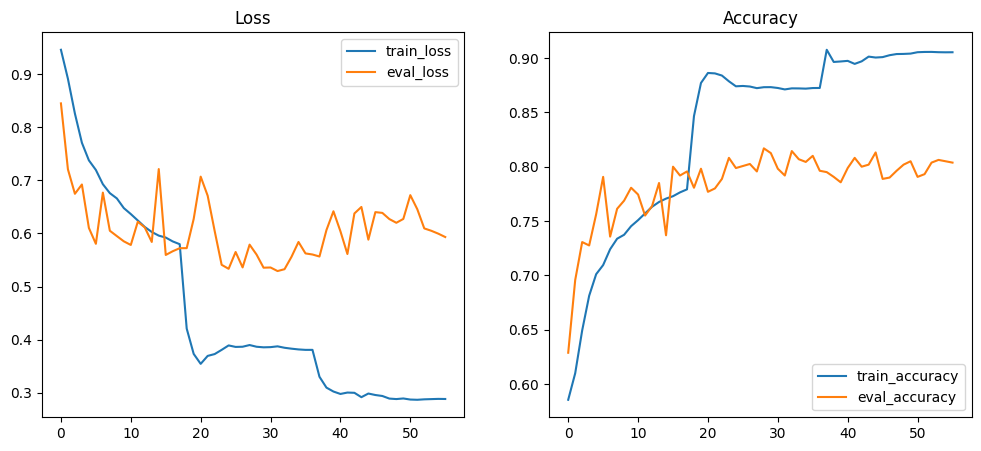

In [28]:
import matplotlib.pyplot as plt
history = log_history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(history['train_loss'], label='train_loss')
ax[0].plot(history['eval_loss'], label='eval_loss')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(history['train_accuracy'], label='train_accuracy')
ax[1].plot(history['eval_accuracy'], label='eval_accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')


plt.show()

In [38]:
def predict(
    args: TrainingArguments,
    model: nn.Module,
    test_dataloader
):
    model.eval()
    preds_list = []
    with torch.no_grad():
        with tqdm(test_dataloader, desc="Predicting", leave=False) as pbar:
            for item in test_dataloader:
                inputs = prepare_input(item, device=args.device)
                outputs = model(inputs["input_ids"], inputs["attention_mask"])

                preds = torch.argmax(outputs.logits.cpu(), dim=-1).numpy()
                preds_list.append(preds)
                pbar.update(1)

    print(f'Prediction Finished!')
    preds = np.concatenate(preds_list, axis=0).tolist()

    return preds

def generate_commit(output_dir, task_name, test_dataset, preds: List[int]):

    pred_test_examples = []
    for idx in range(len(test_dataset)):
        example = test_dataset[idx]
        label  = KUAKEQQR_Dataset.id2label(preds[idx])
        pred_example = {'id': example['id'], 'query1': example['text_a'], 'query2': example['text_b'], 'label': label}
        pred_test_examples.append(pred_example)
    
    with open(os.path.join(output_dir, f'{task_name}_test.json'), 'w', encoding='utf-8') as f:
        json.dump(pred_test_examples, f, indent=2, ensure_ascii=False)

In [39]:
best_state = torch.load(os.path.join(train_args.output_dir, f"checkpoint-{best_steps}", "model.pth"), weights_only=True)

model.load_state_dict(best_state)

preds = predict(train_args, model, test_loader)
generate_commit(train_args.output_dir, data_args.task_name, data["test"], preds)

Prediction Finished!
